In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/iit-bhu-map/Screenshot 2024-06-30 234458.png
/kaggle/input/iit-bhu-map/Screenshot 2024-06-30 234251.png
/kaggle/input/iit-bhu-map/Screenshot 2024-06-30 234528.png
/kaggle/input/mask-and-sat-arrays/sat_train_arrays.npy
/kaggle/input/mask-and-sat-arrays/mask_train_arrays (1).npy


# Please Note
### I have took the images from the dataset given the task and converted them to arrays and each image of shape (256,256,3) and each mask of shape(256,256) and saved them to my device and imported the same, so that i don't waste time on preprocessing and loading again and again

In [2]:
import numpy as np
import tensorflow as tf
import random
tf.random.set_seed(10)
np.random.seed(10)
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model

2024-07-03 17:35:37.365992: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-03 17:35:37.366138: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-03 17:35:37.647579: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
mask_array = np.load("/kaggle/input/mask-and-sat-arrays/mask_train_arrays (1).npy")
sat_array = np.load("/kaggle/input/mask-and-sat-arrays/sat_train_arrays.npy")

In [4]:
x_train, x_test, y_train, y_test = train_test_split(sat_array, mask_array, test_size = 0.25, random_state = 10)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(1875, 256, 256, 3) (1875, 256, 256) (625, 256, 256, 3) (625, 256, 256)


In [5]:
from tensorflow.keras import layers, models, Input
from tensorflow.keras.layers import concatenate, Conv2D, Conv2DTranspose, Dropout, BatchNormalization, Activation, MaxPooling2D, UpSampling2D

## Vgg19 + unet

In [6]:
def conv_block(inp, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inp)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [6]:
def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = layers.MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_vgg19_unet(input_shape):
    
    base_model = tf.keras.applications.VGG19(include_top=False, weights="imagenet", input_shape=input_shape)
    base_model.trainable = False
    
    inputs = vgg19.input
    # Encoder
    s1 = base_model.get_layer("block1_conv2").output  # 256x256
    s2 = base_model.get_layer("block2_conv2").output  # 128x128
    s3 = base_model.get_layer("block3_conv4").output  # 64x64
    s4 = base_model.get_layer("block4_conv4").output  # 32x32

    # Bridge
    b1 = base_model.get_layer("block5_conv4").output  # 16x16

    # Decoder
    d1 = decoder_block(b1, s4, 512)  # 32x32
    d2 = decoder_block(d1, s3, 256)  # 64x64
    d3 = decoder_block(d2, s2, 128)  # 128x128
    d4 = decoder_block(d3, s1, 64)   # 256x256

    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = models.Model(inputs, outputs, name="VGG19_U-Net")
    return model

model = build_vgg19_unet((256, 256, 3))
model.summary()


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "VGG19_U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 256, 256,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 128, 128,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 128, 128,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 128, 128,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 64, 64,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 64, 64,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 64, 64,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 64, 64,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv4        │ (None, 64, 64,    │    590,080 │ block3_conv3[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 32, 32,    │          0 │ block3_conv4[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 32, 32,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 32, 32,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 32, 32,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv4        │ (None, 32, 32,    │  2,359,808 │ block4_conv3[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 16, 16,    │          0 │ block4_conv4[0][

 Total params: 31,172,033 (118.91 MB)

 Trainable params: 11,143,809 (42.51 MB)

 Non-trainable params: 20,028,224 (76.40 MB)

In [7]:
def decoder_block(inp, skip, num_filters):
    x = Conv2DTranspose(filters = inp.shape[-1], kernel_size=(3, 3), strides=(2, 2), padding='same')(inp)
    x = concatenate([x, skip], axis = -1)
    x = conv_block(x, num_filters)
    return x

In [21]:
def eff_and_unet(input_shape = (256,256,3)):
    
    inputs = Input(shape = (256,256,3))
    
    i = inputs
    
    eff = tf.keras.applications.EfficientNetB0(include_top=False,weights='imagenet',input_tensor = inputs)
    
    layer_names = [
        'block2a_expand_activation',#128x128
        'block3a_expand_activation',#64x64
        'block4a_expand_activation',#32x32
        'block6a_expand_activation' #16x16
    ]
    
    layer_outs = [eff.get_layer(layer).output for layer in layer_names]
    layer_outs.append(eff.output) #8x8

    down_stack = models.Model(inputs = eff.input, outputs = layer_outs)
    down_stack.trainable = False
    
    x = down_stack.output[-1]  # Output from EfficientNet
    
    skips = list(reversed(down_stack.output[:-1]) )
    
    
    x = decoder_block(x, skips[0],256) #16x16x256
    x = decoder_block(x, skips[1],128) #32x32x128
    x = decoder_block(x, skips[2],64) #64x64x64
    x = decoder_block(x, skips[3],32) #128x128x32
    
    x = UpSampling2D(size=(2, 2))(x) #256x256x32
    x = conv_block(x, 16) #256x256x16

    outs = Conv2D(1, (1, 1), activation = "sigmoid")(x) #256x256x1
    #outs = Activation("sigmoid")(outs)

    model = models.Model(inputs  = inputs ,  outputs = outs)
    
    return model

In [7]:
plot_model(model, show_layer_names = True, show_shapes = True)

In [9]:
from tensorflow.keras import backend as K

def iou_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    iou = intersection / (union + K.epsilon())
    return iou

def dice_metric(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    dice = (2. * intersection) / (K.sum(y_true) + K.sum(y_pred) + K.epsilon())
    return dice

In [11]:
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

In [10]:
opt = tf.keras.optimizers.Adam(learning_rate = 1e-4)
model.compile(optimizer = opt, loss = "binary_crossentropy", metrics = [iou_metric, dice_metric])

In [11]:
history = model.fit(x_train, y_train, batch_size = 8, epochs = 50, validation_split = 0.2)

Epoch 1/50


2024-07-03 17:39:23.973375: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,128,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,128,256,256]{3,2,1,0}, f32[8,64,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-07-03 17:39:25.010807: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.03755386s
Trying algorithm eng0{} for conv (f32[64,128,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,128,256,256]{3,2,1,0}, f32[8,64,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-07-03 17:39:27.745235: E external/l

188/188 ━━━━━━━━━━━━━━━━━━━━ 265s 900ms/step - dice_metric: 0.1119 - iou_metric: 0.0596 - loss: 0.3726 - val_dice_metric: 0.1838 - val_iou_metric: 0.1019 - val_loss: 0.2494
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 73s 390ms/step - dice_metric: 0.2002 - iou_metric: 0.1118 - loss: 0.1594 - val_dice_metric: 0.2347 - val_iou_metric: 0.1336 - val_loss: 0.1260
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 73s 390ms/step - dice_metric: 0.2566 - iou_metric: 0.1479 - loss: 0.1310 - val_dice_metric: 0.2508 - val_iou_metric: 0.1441 - val_loss: 0.1169
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 73s 390ms/step - dice_metric: 0.3027 - iou_metric: 0.1793 - loss: 0.1156 - val_dice_metric: 0.2761 - val_iou_metric: 0.1610 - val_loss: 0.1115
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 74s 391ms/step - dice_metric: 0.3473 - iou_metric: 0.2114 - loss: 0.1042 - val_dice_metric: 0.3138 - val_iou_metric: 0.1870 - val_loss: 0.1060
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 82s 393ms/step - dice_metric: 0.3936 - iou_metric: 0.24

# PREDICTING RESULTS

In [12]:
def postprocess_masks(pred_masks):
    pred_masks = (pred_masks > 0.5).astype(np.uint8)  # Apply threshold
    pred_masks_squeezed = np.squeeze(pred_masks, axis=-1)  # Remove the last dimension
    return pred_masks_squeezed

In [14]:
y_pred = model.predict(x_test)
y_pred = postprocess_masks(y_pred)
y_pred.shape

2024-07-03 18:47:43.253530: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng36{k2=1,k3=0} for conv (f32[32,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,256,256]{3,2,1,0}, f32[64,128,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-07-03 18:47:43.302861: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.049444702s
Trying algorithm eng36{k2=1,k3=0} for conv (f32[32,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,256,256]{3,2,1,0}, f32[64,128,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0

20/20 ━━━━━━━━━━━━━━━━━━━━ 202s 4s/step


(625, 256, 256)

### VISUALIZING RESULTS

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

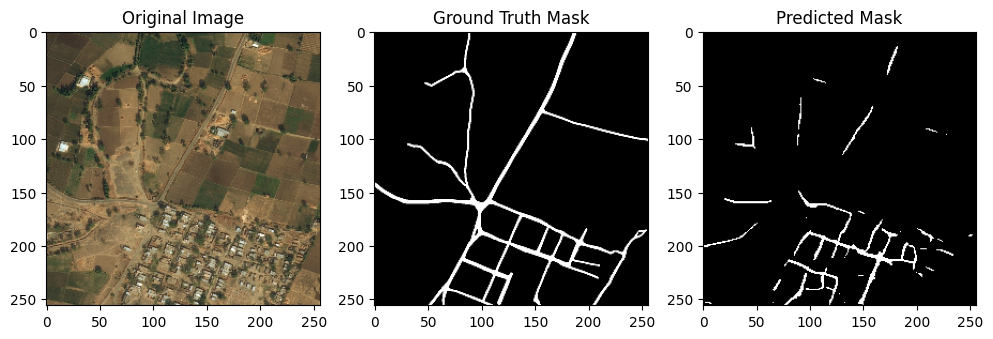

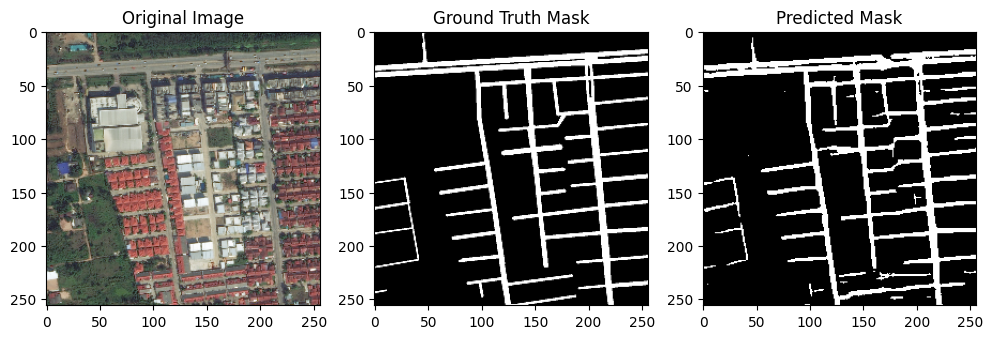

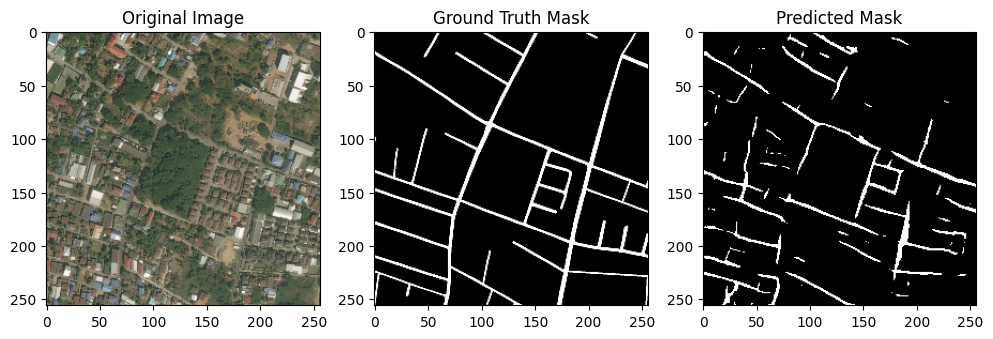

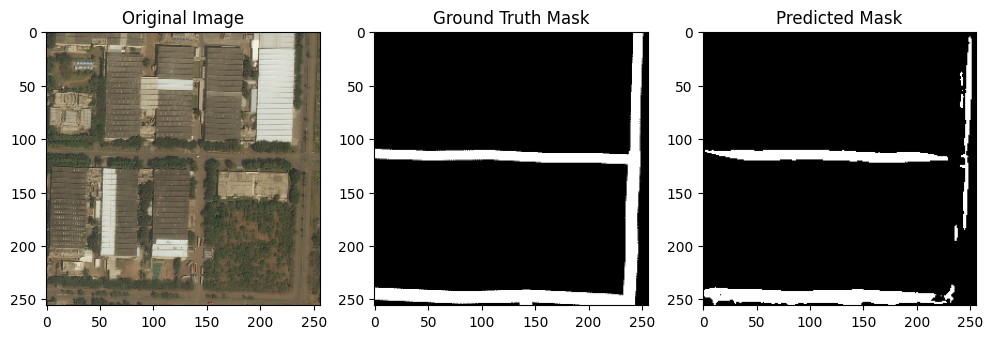

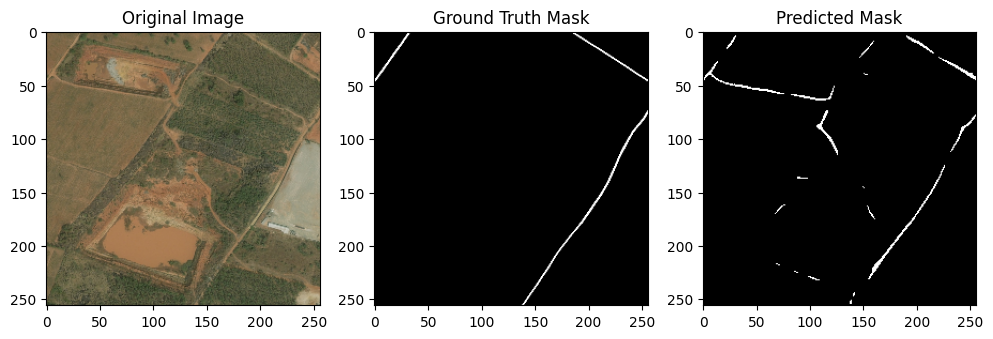

In [28]:
def visualize_results(x_test, y_test, y_pred, num_samples=5):
    indices = random.sample(range(len(x_test)), num_samples)
    for i in indices:
        plt.figure(figsize=(12, 4))
        
        # Original image
        plt.subplot(1, 3, 1)
        plt.imshow(x_test[i])
        plt.title('Original Image')
        
        # Ground truth mask
        plt.subplot(1, 3, 2)
        plt.imshow(y_test[i].reshape(256, 256), cmap='gray')
        plt.title('Ground Truth Mask')
        
        # Predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(y_pred[i].reshape(256, 256), cmap='gray')
        plt.title('Predicted Mask')
        
        plt.show()

# Visualize random results
visualize_results(x_test, y_test, y_pred, num_samples=5)

### IOU SCORE AND DICE FOR VGG19+UNET MODEL

In [17]:
from sklearn.metrics import jaccard_score

def calculate_iou(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    return jaccard_score(y_true, y_pred, average='binary')

In [18]:
ious = [calculate_iou(y_te, y_pr) for y_te, y_pr in zip(np.array(y_test).astype(np.uint8), y_pred)]
average_iou = np.mean(ious)
print("Average IoU:", average_iou)

Average IoU: 0.34257272281531687


In [19]:
def dice_coefficient(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    
    dice = (2. * intersection + tf.keras.backend.epsilon()) / (union + tf.keras.backend.epsilon())
    
    return dice

In [20]:
dices = [dice_coefficient(y_te, y_pr) for y_te, y_pr in zip(np.array(y_test).astype(np.uint8), y_pred)]
average_dice = np.mean(dices)
print("Average DICE:", average_dice)

Average DICE: 0.48698202


# RESULT(VGG19 + UNET)...
### Average DICE = 0.48698202
### Average IoU = 0.34257272

# ------------------------------------------------------

# IIT BHU PREDICTION-----------------------------

In [21]:
import cv2

In [41]:
image = cv2.imread('/kaggle/input/iitbhu-map2/Screenshot 2024-07-04 003216.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [31]:
x= cv2.imread("/kaggle/input/iit-bhu-map/Screenshot 2024-06-30 234458.png")
x = resize_image_with_padding(x)
x = np.expand_dims(x, axis = 0)

(895, 1026, 3)


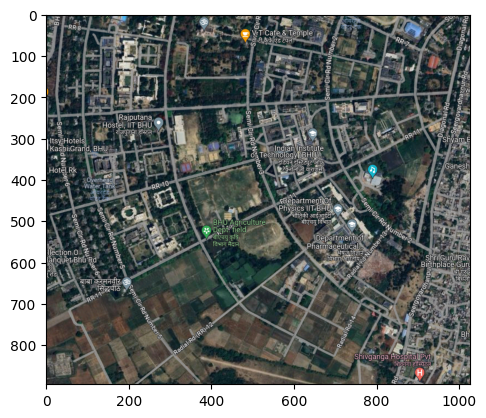

In [42]:
print(image.shape)
plt.imshow(image)

In [68]:
def resize_image_with_padding(image, target_size=(256, 256)):
    # Get dimensions
    h, w = image.shape[:2]
    target_w, target_h = target_size
    
    # Determine the scale and padding
    scale = min(target_w / w, target_h / h)
    new_w, new_h = int(w * scale), int(h * scale)
    pad_w, pad_h = (target_w - new_w) // 2, (target_h - new_h) // 2
    
    # Resize the image
    resized_image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
    
    # Create a new image and place the resized image in the center
    padded_image = np.full((target_h, target_w, 3),150, dtype=np.uint8)
    padded_image[pad_h:pad_h + new_h, pad_w:pad_w + new_w] = resized_image
    
    return padded_image

In [69]:
img = resize_image_with_padding(image)
print(img.shape)

(256, 256, 3)


In [70]:

#img1 = np.expand_dims(img1, axis = 0)
#img2 = np.expand_dims(img2, axis = 0)
img = np.expand_dims(img, axis = 0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


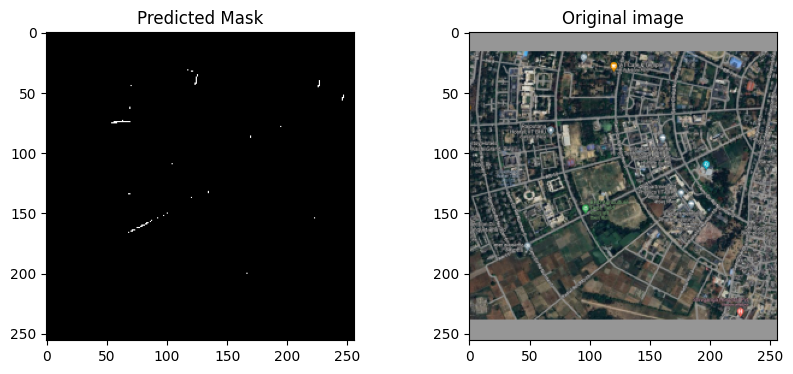

In [71]:
y = model.predict(img)
y = postprocess_masks(y)
plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.imshow(y.reshape(256,256), cmap = "gray")
plt.title("Predicted Mask")

plt.subplot(1,2,2)
plt.imshow(img.reshape(256,256,3))
plt.title("Original image");

# wtf!!! Despite having such better  score on training and validation data, it gave worst performance on IIT BHU campus, idk why!🤔🤔🤔